In [19]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras.backend as K
%matplotlib inline

In [20]:
# reading the labels of training data
train_set = pd.read_csv('/content/drive/MyDrive/Mtech Project/Dataset/Messidor/train.csv')    # reading the csv file
train_image = []

#loading training data using the labels
for i in tqdm(range(train_set.shape[0])):
    img = image.load_img('../content/drive/MyDrive/Mtech Project/Dataset/Messidor/train/' + train_set['Image'][i],target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)

# reading the labels of testing data            
test_set =  pd.read_csv('/content/drive/MyDrive/Mtech Project/Dataset/Messidor/test.csv')    # reading the csv file
test_image = []

#loading testing data using the labels
for i in tqdm(range(test_set.shape[0])):
    img = image.load_img('../content/drive/MyDrive/Mtech Project/Dataset/Augmented Messidor*5/test/' + test_set['Image'][i],target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)

Y = np.array(test_image)

100%|██████████| 240/240 [00:09<00:00, 25.32it/s]


In [21]:
y = np.array(train_set.drop(['Image', 'Risk of macular edema '],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [22]:
model = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    classes=1000,
                    classifier_activation="softmax",
                )

In [ ]:
model.summary()

In [24]:
base_in=model.input
base_out=model.output

In [25]:
base_out.shape

TensorShape([None, 5, 5, 2048])

In [26]:
def se_block(input_shape, ch, ratio=16):
  shape = K.int_shape(input_shape)
  x = tf.keras.layers.AveragePooling2D(pool_size=(shape[1],shape[2]))(input_shape)
  print(x.shape)
  x = Dense(ch//ratio, activation='relu')(x)
  print(x.shape)
  x = Dense(ch, activation='sigmoid')(x)
  print(x.shape)
  se = tf.keras.layers.Multiply()([input_shape, x])
  return se

In [27]:
base_out.shape

TensorShape([None, 5, 5, 2048])

In [31]:
shape = K.int_shape(base_out)
ch = shape[3]
attention = se_block(base_out,ch)
#x = Dense(4, activation='softmax')(attention)
'''
densenet121_model.add(Flatten())
densenet121_model.add(Dense(512, activation='relu'))
densenet121_model.add(Dense(4, activation='softmax'))
'''
x = Flatten()(attention)
x = Dense(512,activation='relu')(x)
out = Dense(4,activation='softmax')(x)

(None, 1, 1, 2048)
(None, 1, 1, 128)
(None, 1, 1, 2048)


In [33]:
out.shape

TensorShape([None, 4])

In [37]:
model.trainable = False
se_model = keras.Model(inputs=model.input, outputs=out)


In [ ]:
se_model.summary()

In [38]:
print(se_model.output.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(None, 4)
(864, 224, 224, 3)
(96, 224, 224, 3)
(864, 1)
(96, 1)


In [39]:
#setting hyperparameters categorical_crossentropy
se_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

#training
history = se_model.fit(X_train, y_train,
          batch_size=4,
          epochs=15,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/15
216/216 [==============================] - 203s 916ms/step - loss: 1.2498 - accuracy: 0.4792 - val_loss: 1.1383 - val_accuracy: 0.4896
Epoch 2/15
216/216 [==============================] - 210s 973ms/step - loss: 1.0211 - accuracy: 0.5845 - val_loss: 1.2592 - val_accuracy: 0.4062
Epoch 3/15
216/216 [==============================] - 206s 956ms/step - loss: 0.8446 - accuracy: 0.6470 - val_loss: 1.2289 - val_accuracy: 0.5000
Epoch 4/15
216/216 [==============================] - 199s 922ms/step - loss: 0.6513 - accuracy: 0.7477 - val_loss: 1.3237 - val_accuracy: 0.3958
Epoch 5/15
216/216 [==============================] - 194s 899ms/step - loss: 0.4432 - accuracy: 0.8461 - val_loss: 1.4430 - val_accuracy: 0.5104
Epoch 6/15
216/216 [==============================] - 203s 941ms/step - loss: 0.2769 - accuracy: 0.9155 - val_loss: 1.6875 - val_accuracy: 0.5104
Epoch 7/15
216/216 [==============================] - 194s 899ms/step - loss: 0.1473 - accuracy: 0.9676 - val_loss: 1.7351 -

In [40]:
score = se_model.evaluate(X_test, y_test, verbose=0)
print("Hyperparameters : {} \n".format(se_model.optimizer.get_config()))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Hyperparameters : {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False} 

Test loss: 2.441356897354126
Test accuracy: 0.53125


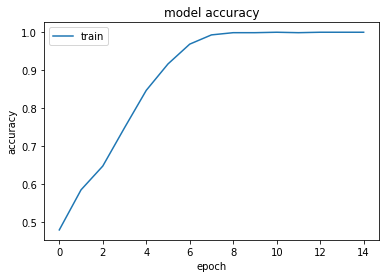

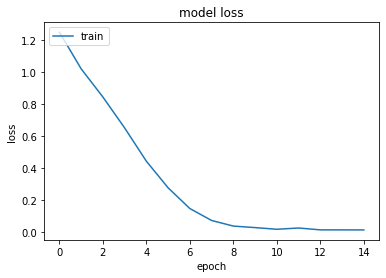

In [42]:
#Plotting the graph of accuracy VS epoch
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

#Plotting the graph of loss VS epoch
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()